<a href="https://colab.research.google.com/github/musical-shyam/CS-536-ML-Projects/blob/main/Assignment-3/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro to ML Assignment - 3**

## **Importing the necessary modules**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Subset

# To Calculate the training Time
import time

# To split the training data set for Kfold validation
from sklearn.model_selection import KFold

# To store the trained model
from google.colab import drive

# For printing the Confusion matrix
import seaborn as sns
import sklearn.metrics as confusion_matrix

## **Data Preprocessing**

In [ ]:
# Creating a preprocessing pipeline
# .ToTensor() to scale pixel values from 0 - 256 values to 0 - 1
# .Normalize() to substract 0.5 and divide by 0.5. so that the range becomes -1 to 1
# .Compose() to chain multiple tranformations together
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader loads only 4 images everytime trainloader is called. before calling it shuffles the dataset and the num of parallel processes is 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 63.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


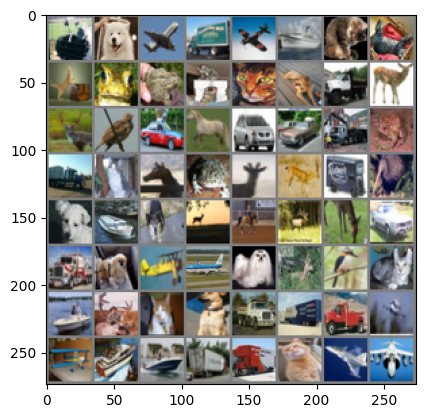

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()     # Convert it into numpy array for plot
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # tensor image normally has (channels, height, weight), matplot lib takes (height, weight, channels)
    plt.show()
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## **Training and Validation**

### Train and Evaluate Functions - 5-Fold validation

In [ ]:
drive.mount('/content/drive')

# Function for Calculating Accuracy
def calculate_accuracy(loader, model):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in loader:
      images, labels = data
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return 100 * correct / total

def train_and_evaluate_model(model, criterion, optimizer, num_epochs, model_name = 'model.pth'):
  # Initializing the 5 fold validation
  kfold = KFold(n_splits=5, shuffle=True)

  # Switching to GPU if available
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  # Split trainset into 80% for training and 20% for validation
  train_size = int(0.8 * len(trainset)) # 40000
  val_size = len(trainset) - train_size # 10000
  train_ds, val_ds = random_split(trainset, [train_size, val_size])

  # Initilizing the variables needed for measuring the model
  total_training_time = 0
  fold_accuracy = []

  for fold, (train_ids, test_ids) in enumerate(kfold.split(train_ds)):
    print(f'Fold {fold+1}')

    # Loading the Data Subsets
    train_data = Subset(train_ds, train_ids)
    val_data = Subset(val_ds, test_ids)
    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    # Reset Model Parameters for each fold
    model.apply(lambda layer:layer.reset_parameters() if hasattr(layer, 'reset_parameters') else None)

    # Starting to measure the fold time
    start_time = time.time()

    # Training the model
    for epoch in range(num_epochs):
      epoch_start_time = time.time()
      model.train()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
        # loading the inputs and labels using GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

      epoch_training_time = time.time() - epoch_start_time
      print(f'[{epoch + 1}] loss: {running_loss / len(trainloader)}   Training time: {epoch_training_time:.2f} seconds')

    fold_training_time = time.time() - start_time
    total_training_time += fold_training_time
    print(f'Training time for fold {fold+1}: {fold_training_time:.2f} seconds')

    # Calculate accuracy on validation set
    fold_acc = calculate_accuracy(valloader, net)
    fold_accuracy.append(fold_acc)
    print(f'Validation Accuracy for fold {fold+1}: {fold_acc:.2f}%\n')

  # Print the average accuracy and total time
  average_accuracy = np.mean(fold_accuracy)
  print(f'Average Validation Accuracy across folds: {average_accuracy:.2f}%')
  print(f'Total Training Time:{(total_training_time//60):.2f} minutes {(total_training_time%60):.2f} seconds')

  # Save the model
  save_path = f"/content/drive/MyDrive/{model_name}"
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to {save_path}')
  # Model size calculation (approximate, in MB)
  model_size = sum(p.numel() for p in net.parameters() if p.requires_grad) * 4 / (1024 ** 2)
  print(f'Approximate Model Size: {model_size:.2f} MB')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Defining the Deep Learning Models

#### Deep Neural Network similar to LeNet - 5

In [ ]:
# Total Number of Layers = 5
# Number of Convolution Layers = 2
# Number of Pooling Layers = 2
# Number of Fully Connected Layers = 3
class Net(nn.Module):
  def __init__(self):
    super().__init__() # calls nn.Module sub class from the pytorch
    self.conv1 = nn.Conv2d(3, 6, 5) # Defining a Convolution layer that takes 3 inputs and 6 kernels of size 5X5 (output size (n-4)X(n-4))
    self.pool = nn.MaxPool2d(2, 2) # Defining a Pooling layer that Pool the layer with a 2X2 kernel and a stride of 2 (output size (n/2)X(n/2))
    self.conv2 = nn.Conv2d(6, 16, 5) # Defining a Convolution layer that takes 6 inputs and 16 kernels of size 5X5 (output size (n-4)X(n-4))
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # Defining a Fully Connected Layer that takes the flattened input arr of size 400 and returning 120 outputs
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x))) # passing inputs through conv layer then relu then maxpool them
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_and_evaluate_model(net, criterion, optimizer, 70, model_name = 'lenet.pth')

Fold 1
[1] loss: 2.297849127960205   Training time: 6.86 seconds
[2] loss: 2.2024278732299805   Training time: 6.30 seconds
[3] loss: 1.9500642908096313   Training time: 7.01 seconds
[4] loss: 1.7385233932495117   Training time: 6.11 seconds
[5] loss: 1.6120737619400025   Training time: 7.22 seconds
[6] loss: 1.5327677438735963   Training time: 6.92 seconds
[7] loss: 1.4779753494262695   Training time: 7.13 seconds
[8] loss: 1.426943434715271   Training time: 6.56 seconds
[9] loss: 1.3818245208740234   Training time: 7.02 seconds
[10] loss: 1.3433797231674194   Training time: 6.90 seconds
[11] loss: 1.311366796207428   Training time: 6.87 seconds
[12] loss: 1.2811160484313966   Training time: 7.27 seconds
[13] loss: 1.2551424271583558   Training time: 6.66 seconds
[14] loss: 1.221839403438568   Training time: 6.48 seconds
[15] loss: 1.199527477836609   Training time: 6.78 seconds
[16] loss: 1.1752141892433166   Training time: 7.32 seconds
[17] loss: 1.1508659930229188   Training time: 

#### Deep Neural Network  similar to ResNet - 18

In [ ]:
# Total Number of Layers: 18 Layers
# Number of blocks: 4
# Total Number of Convolution layers:
class Residual(nn.Module):
  def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
    else:
      blk.append(Residual(out_channels, out_channels))
  return blk
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
resnet = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

train_and_evaluate_model(resnet, criterion, optimizer, 15, model_name = 'resnet.pth')

Fold 1
[1] loss: 1.319205214214325   Training time: 64.29 seconds
[2] loss: 0.8651556259155273   Training time: 65.22 seconds
[3] loss: 0.640272962141037   Training time: 65.80 seconds
[4] loss: 0.4731698485612869   Training time: 66.25 seconds
[5] loss: 0.33530540717840196   Training time: 65.64 seconds
[6] loss: 0.2462280388057232   Training time: 66.02 seconds
[7] loss: 0.16421357347667218   Training time: 66.24 seconds
[8] loss: 0.11591237531900406   Training time: 66.25 seconds
[9] loss: 0.08952290482670068   Training time: 65.89 seconds
[10] loss: 0.08250097277164459   Training time: 65.58 seconds
[11] loss: 0.056779510732740165   Training time: 68.59 seconds
[12] loss: 0.05215139482207596   Training time: 65.72 seconds
[13] loss: 0.04410328474268317   Training time: 66.86 seconds
[14] loss: 0.03105799764096737   Training time: 65.67 seconds
[15] loss: 0.024012614973261952   Training time: 67.21 seconds
Training time for fold 1: 991.23 seconds
Validation Accuracy for fold 1: 78.8

#### Deep Neural Network  similar to VGG - 18

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
      # Block 1
      nn.Conv2d(3,64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64,64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2), # Output 64 X 16 X 16

      # Block 2
      nn.Conv2d(64,128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128,128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2), # Output: 128 X 8 X 8

      )
    self.classifier = nn.Sequential(
      nn.Linear(128 * 8 * 8, 128),
      nn.ReLU(inplace=True),
      nn.Linear(128, 10)
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

vgg = VGG()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

train_and_evaluate_model(vgg, criterion, optimizer, 20, model_name = 'vgg.pth')

Fold 1
[1] loss: 2.293265835571289   Training time: 25.58 seconds
[2] loss: 1.9718459825515746   Training time: 26.76 seconds
[3] loss: 1.722676792907715   Training time: 26.58 seconds
[4] loss: 1.5732110164642334   Training time: 24.95 seconds
[5] loss: 1.4560663131713867   Training time: 25.01 seconds
[6] loss: 1.3712239506721497   Training time: 26.41 seconds
[7] loss: 1.2967078451156617   Training time: 26.17 seconds
[8] loss: 1.2258903292655945   Training time: 26.91 seconds
[9] loss: 1.1644332341194152   Training time: 26.10 seconds
[10] loss: 1.0980151386260986   Training time: 25.31 seconds
[11] loss: 1.033840604019165   Training time: 25.79 seconds
[12] loss: 0.9790302235603332   Training time: 25.89 seconds
[13] loss: 0.9168823198318481   Training time: 26.10 seconds
[14] loss: 0.8635735873222351   Training time: 25.19 seconds
[15] loss: 0.8105061673164368   Training time: 24.93 seconds
[16] loss: 0.7621169180870057   Training time: 26.02 seconds
[17] loss: 0.715295799779892 

In [ ]:
# Initialize models
lenet = LeNet()
vgg = VGG()
resnet = ResNet()

# Load state_dicts into each model
lenet.load_state_dict(torch.load('lenet.pth'))
vgg.load_state_dict(torch.load('vgg.pth'))
resnet.load_state_dict(torch.load('resnet.pth'))

# Function to calculate model size
def calculate_model_size(model):
    model_size = sum(p.numel() for p in model.parameters() if p.requires_grad) * 4 / (1024 ** 2)
    return model_size

# Print model sizes
print(f'Approximate Model Size of LeNet: {calculate_model_size(lenet):.2f} MB')
print(f'Approximate Model Size of VGG: {calculate_model_size(vgg):.2f} MB')
print(f'Approximate Model Size of ResNet: {calculate_model_size(resnet):.2f} MB')

## **Testing the Best Model**

<ipython-input-20-d266354c4619>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 71.25%


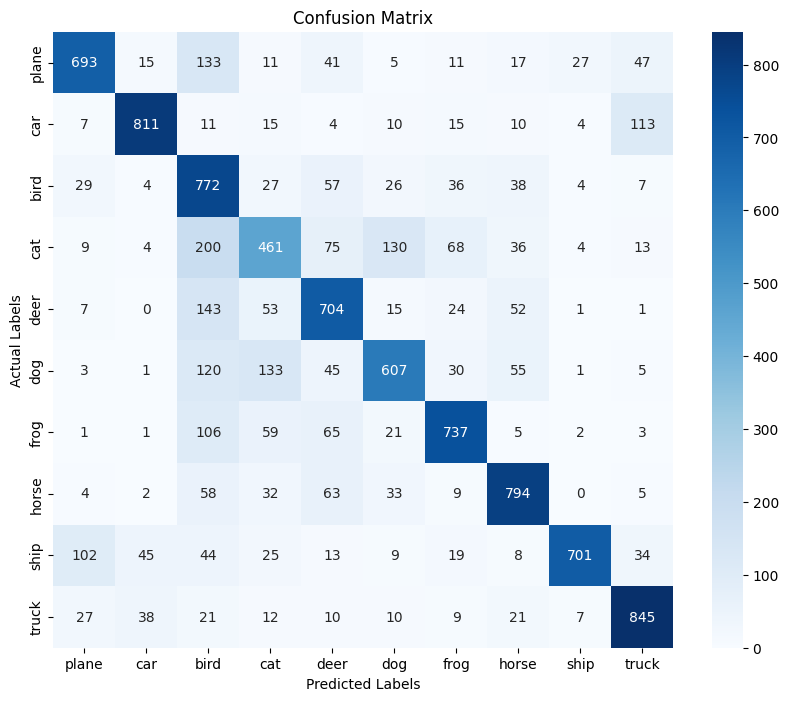

In [ ]:
dataiter = iter(testloader)

# Load the best model
best_model_path = '/content/resnet.pth'
best_model = resnet
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Pred = []
Actual = []
with torch.no_grad():
  total = 0
  correct = 0

  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = best_model(images)
    _, predicted = torch.max(outputs.data, 1)
    Pred.extend(predicted.cpu().numpy())
    Actual.extend(labels.cpu().numpy())

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

# Test Accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Confusion Matrix
cm = confusion_matrix.confusion_matrix(Actual, Pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()



## **Testing Different Hypothesis**

**Part-2**<br>
Taking LeNet-5 model, and testing how Batch size, input sample size, regularization affects the model

In [ ]:
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_test_hypothesis(batch_size, model = vgg, epochs =10, regularization = 0, input_size = None):
    # Load data with the given batch size

    if input_size is not None:
      train_subset = torch.utils.data.Subset(trainset, range(input_size))
    else:
      train_subset = trainset

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Instantiate a new model for each run
    criterion = torch.nn.CrossEntropyLoss()
    if regularization == 0:
      optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    else:
      optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= regularization)

    epoch_losses = []
    # Training
    start_time = time.time()
    model.to(device)
    for epoch in range(epochs):  # Assuming 50 epochs
        epoch_loss = 0
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(trainloader)
        epoch_losses.append(epoch_loss)

    training_time = time.time() - start_time

    # Testing
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total

    return epoch_losses, test_accuracy, training_time

### Testing the effect of Batch Size

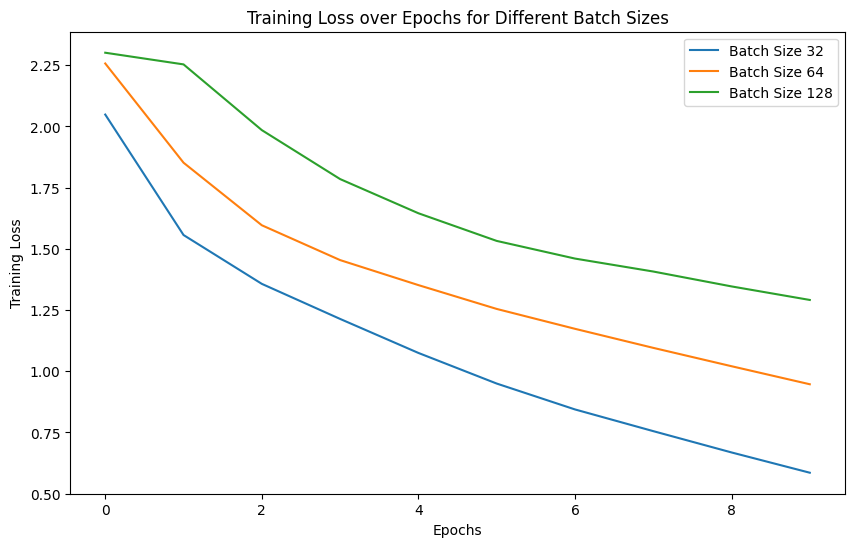

   Batch Size  Test Accuracy (%)  Training Time (seconds)
0          32              71.91               327.085720
1          64              65.16               245.702905
2         128              54.14               351.951035


In [ ]:
batch_sizes = [32, 64, 128]
accuracies =[]
training_times = []
loss_curves = {}

# Loop through each batch size and record accuracy and training time
for batch_size in batch_sizes:
    model = VGG()  # Initialize a fresh model for each run
    losses, accuracy, train_time = train_test_hypothesis(batch_size, model = model)
    accuracies.append(accuracy)
    training_times.append(train_time)
    loss_curves[batch_size] = losses

# Plot the training loss curves for each batch size
plt.figure(figsize=(10, 6))
for batch_size in batch_sizes:
    plt.plot(loss_curves[batch_size], label=f'Batch Size {batch_size}')
plt.title("Training Loss over Epochs for Different Batch Sizes")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

# Display test accuracy and training time in a table
results_df = pd.DataFrame({
    "Batch Size": batch_sizes,
    "Test Accuracy (%)": accuracies,
    "Training Time (seconds)": training_times
})
print(results_df)

### Testing the effect of Regularization

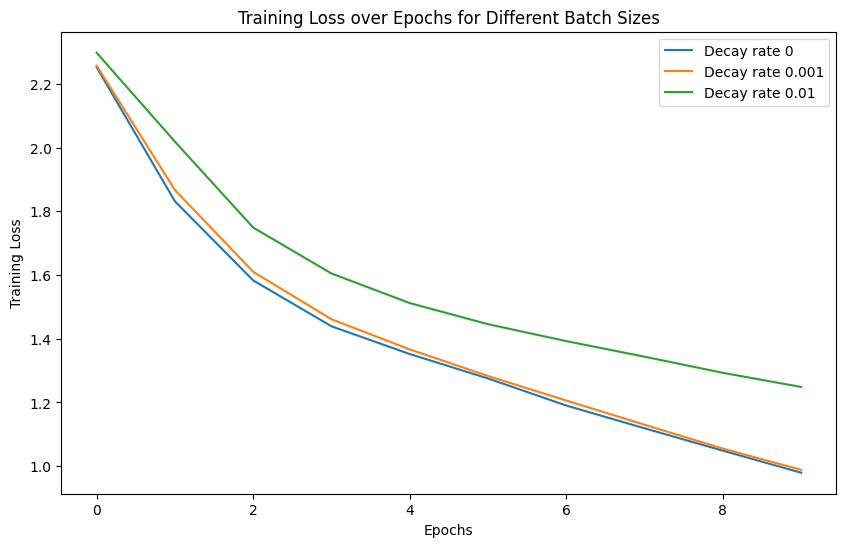

   Batch Size  Test Accuracy (%)  Training Time (seconds)
0          32              63.76               247.620497
1          64              64.17               252.938504
2         128              53.46               249.325212


In [ ]:
batch_size = 64
accuracies =[]
training_times = []
reg = [0, 0.001, 0.01]
loss_curves = {}

for weight_decay in reg:
    model = VGG()  # Initialize a fresh model for each run
    losses, accuracy, train_time = train_test_hypothesis(
        batch_size=batch_size, model=model, epochs=10, regularization=weight_decay
    )
    accuracies.append(accuracy)
    training_times.append(train_time)
    loss_curves[weight_decay] = losses

# Plot the training loss curves for each batch size
plt.figure(figsize=(10, 6))
for weight_decay in reg:
    plt.plot(loss_curves[weight_decay], label=f'Weight Decay rate {weight_decay}')
plt.title("Training Loss over Epochs for Different Decay rates")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

# Display test accuracy and training time in a table
results_df = pd.DataFrame({
    "Decay rates": weight_decay,
    "Test Accuracy (%)": accuracies,
    "Training Time (seconds)": training_times
})
print(results_df)

### Testing the effect of Input Size

In [ ]:
batch_size = 64
accuracies =[]
training_times = []
loss_curves = {}
input_sizes = [30000, 40000, 50000]

for input_size in input_sizes:
    model = VGG()  # Initialize a fresh model for each run
    losses, accuracy, train_time = train_test_hypothesis(
        batch_size=batch_size, model=model, epochs=10, input_size=input_size
    )
    accuracies.append(accuracy)
    training_times.append(train_time)
    loss_curves[input_size] = losses

# Plot the training loss curves for each batch size
plt.figure(figsize=(10, 6))
for input_size in input_sizes:
    plt.plot(loss_curves[input_size], label=f'Input Size {input_size}')
plt.title("Training Loss over Epochs for Different Input Sizes")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

# Display test accuracy and training time in a table
results_df = pd.DataFrame({
    "Input Size": input_sizes,
    "Test Accuracy (%)": accuracies,
    "Training Time (seconds)": training_times
})
print(results_df)

KeyError: 30000

<Figure size 1000x600 with 0 Axes>